# Consinstently estimating Markov Chains with Noisy Aggregated Data

## Notebook con esperimenti numerici per il seminario di fine corso di Metodi Numerici per le Catene di Markov (versione stazionaria)

In [1]:
# to avoid the pain of restarting the kernel each time
%load_ext autoreload
%autoreload 2

In [2]:
# Import some basic stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.estimators import P_mom_stationary, P_cls_stationary
from utilities.data import generate_random_P, create_observations

In [3]:
# Fissiamo il numero di stati
S = 10

# Fissiamo il seed per la riproducibilità degli esperimenti
SEED = 42

### Experiment n° 1

For the first experiment, we want to examine the behaviour of the MoM and CLS estimators for different values of $T$ and $K$. 

In particular, we want to plot the approximation error against $T\times K$. The approximation error is measured as $\frac{1}{S^2}{\lvert\lvert\hat{P}-P\rvert\rvert}_F^2$

The first thing we do is to generate the true transition matrix $P\in\mathbb{R}^{S\times S}$.

Just like the authors, we choose $S=10$, and each row will have a Dirichlet distribution: $P[i,\colon]\sim\operatorname{Dirichlet}\left(\frac{D}{S}\mathbf{e}\right)$, where $D$ is the precision parameter and $\mathbf{e}$ is the vector of all ones.  

In [4]:
# D=0.5 (like in the article)
D = 0.5
P = generate_random_P(S,'dirichlet',precision=D,rng=np.random.default_rng(SEED))

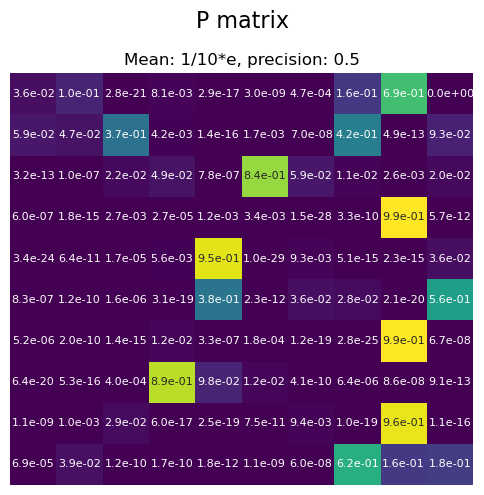

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle('P matrix', fontsize=16)
plt.title(f"Mean: 1/{S}*e, precision: {D}")

sns.heatmap(P, ax=ax, cmap='viridis', annot=True, fmt=".1e", annot_kws={"size": 8}, cbar=False, xticklabels=False, yticklabels=False)

plt.tight_layout()
plt.show()

Then we need to compute the steady-state vector $\pi$, because in the stationary case we use that as initial distribution.

As seen during the course, there are many ways to do it. Since the size of $P$ is modest, I go for a direct method.

In [6]:
from utilities.num_methods import compute_stationary_LU_GTH

# Initial distribution computation

pi_gth= compute_stationary_LU_GTH(P)
print(f"The norm of pi_gth @ (I-P) = {np.linalg.norm(pi_gth@(np.eye(S)-P))}")

# We set the initial distribution
pi_0 = pi_gth

The norm of pi_gth @ (I-P) = 6.360302297111368e-17


The function `create_observations` generates the data, and automatically adds noise to it, if specified.

Data is generated by drawing $n_t\sim\mathrm{Multinomial}(N,\pi)$ for each $t\in[T]$. We immediately generate $K$ independent observations (noise is added later, independently).

Since the process is (strongly) stationary, each $n_t$ is a multinomial draw from the invariant distribution. That is, contrary to the nonstationary case, the parameter of the multinomial doesn't need to be updated.

**OSS**: Let `n_array, y_array, A = create_observations(...)` 

Then `n_array` and `y_array` are `np.ndarray`s of shape $T\times K\times S$. 

They can be thought as lists of length $T$ in which the item at position $t\in\{0,\dots,T-1\}$ is a $K\times S$ `np.ndarray` that contains the $K$ observations for timestep $t+1$.

Instead, `A` is a $S$ by $S$ `np.ndarray`

We're ready

In [7]:
# choice of the error's distribution parameters
alpha = [1, 0.5, 0.25]
variance = [0, 1, 5]

# ranges
T_range = [10**k for k in range(1,5)]
K_range = [1, 2, 5, 10, 20, 50]

# other parameters
n_reps = 10
N = 100

In [ ]:
from itertools import product
from tqdm import tqdm

def error_computation(M:np.ndarray) -> float: 
    return np.linalg.norm(M-P,'fro')/(S**2)

class BreakLoopException(Exception):
    pass


gauss_errors = []
binomial_errors = []

try: 
    prod = product(T_range, K_range, range(0,3))
    for T, K, i in tqdm(prod):
        # Create dictionaries to store data
        gauss_dict_entry = {
            'variance': variance[i],
            'TxK': T*K
        }
        binom_dict_entry = {
            'alpha': alpha[i],
            'TxK': T*K
        }

        # Just like the authors, we repeat each combination 10 times
        for rep in range(n_reps):
            # Generate data
            _, y_array_gauss, A_gauss = create_observations(T=T,
                                                            K=K,
                                                            N=N,
                                                            pi_0=pi_0,
                                                            stationary=True,
                                                            noise_type='gaussian',
                                                            stdev=np.sqrt(variance[i]),
                                                            rng = np.random.default_rng(SEED))
            _, y_array_binom, A_binom = create_observations(T=T,
                                                            K=K,
                                                            N=N,
                                                            pi_0=pi_0,
                                                            stationary=True,
                                                            noise_type = 'binomial',
                                                            alpha=alpha[i],
                                                            rng = np.random.default_rng(SEED)) 
        
            # method of moments estimator
            P_mom_gauss, _, _ = P_mom_stationary(y_array=y_array_gauss, A=A_gauss, N=N)
            P_mom_binom, _, _ = P_mom_stationary(y_array=y_array_binom, A=A_binom, N=N)
            # CLS estimator
            P_cls_gauss = P_cls_stationary(y_array = y_array_gauss)
            P_cls_binom = P_cls_stationary(y_array = y_array_binom)

            #if np.isnan(error_computation(P_mom_gauss)):
            #    print("A NaN value has been encountered while computing the error on MoM estimator (Gauss).")
            #    print(f"K = {K}, T = {T}, sigma^2 = {variance[i]}, repetition = {rep+1}")
            #    raise BreakLoopException
                
            #if np.isnan(error_computation(P_mom_binom)):
            #    print("A NaN value has been encountered while computing the error on MoM estimator (Binomial).")
            #    print(f"K = {K}, T = {T}, alpha = {alpha[i]}, repetition = {rep+1}")
            #    raise BreakLoopException

            # compute & store errors
            gauss_dict_entry[f'error_MoM_{rep}'] = error_computation(P_mom_gauss)
            gauss_dict_entry[f'error_CLS_{rep}'] = error_computation(P_cls_gauss)

            binom_dict_entry[f'error_MoM_{rep}'] = error_computation(P_mom_binom)
            binom_dict_entry[f'error_CLS_{rep}'] = error_computation(P_cls_binom)

        # store combination
        gauss_errors.append(gauss_dict_entry)
        binomial_errors.append(binom_dict_entry)

except BreakLoopException:
    print("Emergency brake has been pulled.")
    print("Please investigate.")



0it [00:00, ?it/s]

/media/andrea/Windows/Users/marin/Documents/Programmazione/MNCM Lab/MNCM-project/Codice/utilities/estimators.py:97: RuntimeWarning: invalid value encountered in divide
  P_mom = ((Sigma_hat/N+np.outer(mu_hat,mu_hat)).T/mu_hat).T
72it [03:29,  2.91s/it]


#### `NaN`s checking, and other checkings in general

As of now, there is a problem with the `NaN`s, and I don't think we'll ever get rid of them.

In [ ]:
P_mom_guilty, _, _ = P_mom_stationary(y_array=y_array_binom, A = A_binom, N=N)

has_nan_or_inf = np.any(np.isnan(P_mom_guilty)) or np.any(np.isinf(P_mom_guilty))
print(f"Matrix contains NaN or infinite values: {has_nan_or_inf}")

if has_nan_or_inf:
    print(f"The matrix has {np.isnan(P_mom_guilty).sum()} NaNs")
    print(f"The matrix has {np.isinf(P_mom_guilty).sum()} Infs")

    # Print coordinates of NaNs
    nan_coords = np.argwhere(np.isnan(P_mom_guilty))
    print("Coordinates of NaNs:")
    for coord in nan_coords:
        print(coord)

Matrix contains NaN or infinite values: True
The matrix has 10 NaNs
The matrix has 0 Infs
Coordinates of NaNs:
[0 0]
[0 1]
[0 2]
[0 3]
[0 4]
[0 5]
[0 6]
[0 7]
[0 8]
[0 9]


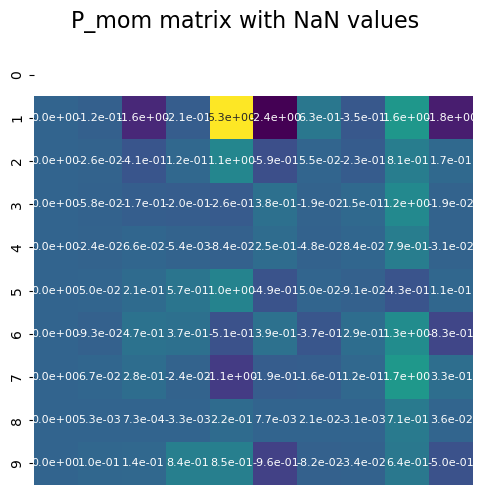

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle('P_mom matrix with NaN values', fontsize=16)

sns.heatmap(P_mom_guilty, ax=ax, 
			cmap='viridis', annot=True, fmt=".1e", annot_kws={"size": 8}, 
			cbar=False, xticklabels=False, yticklabels=True)
plt.tight_layout()
plt.show()

In [22]:
# Mean across the temporal (T) dimension
y_array_gauss.mean(axis=0).squeeze()

array([ 0. ,  0.3,  2.7,  1.9, 17. ,  2. ,  1.1,  1.4, 71.1,  2.5])

In [17]:
m_t_hat_guilty = y_array_gauss.mean(axis=(0,1))
print(m_t_hat_guilty)



[ 0.   0.3  2.7  1.9 17.   2.   1.1  1.4 71.1  2.5]


Ok the problem is due to a zero division

This is to check if the observations are identical:

In [23]:
check_mom, check_cls = [], []
for dict_entry in gauss_errors:
    lista_mom = np.array([dict_entry[f'error_MoM_{i}'] for i in range(n_reps)])
    lista_cls = np.array([dict_entry[f'error_CLS_{i}'] for i in range(n_reps)])

    check_mom.append(len(np.unique(lista_mom)) == 1)
    check_cls.append(len(np.unique(lista_cls)) == 1)

print(f"Trials with MoM are all equal: {all(check_mom)}")
print(f"Trials with CLS are all equal: {all(check_cls)}")

Trials with MoM are all equal: True
Trials with CLS are all equal: True


---

#### Let's move on

In [9]:
print(f'len(gauss_errors) = {len(gauss_errors)},\t check: {len(T_range)*len(K_range)*len(variance)}')
gauss_errors[0]

len(gauss_errors) = 72,	 check: 72


{'variance': 0,
 'TxK': 10,
 'error_MoM_0': 0.07239187721377982,
 'error_CLS_0': 0.18812210725216974,
 'error_MoM_1': nan,
 'error_CLS_1': 0.08772241296673049,
 'error_MoM_2': nan,
 'error_CLS_2': 0.13719395642015997,
 'error_MoM_3': nan,
 'error_CLS_3': 0.692117517231646,
 'error_MoM_4': nan,
 'error_CLS_4': 4.3314420371771085,
 'error_MoM_5': nan,
 'error_CLS_5': 0.2727065191327273,
 'error_MoM_6': nan,
 'error_CLS_6': 0.16452261985493272,
 'error_MoM_7': 0.07516499157401613,
 'error_CLS_7': 0.2471169960665492,
 'error_MoM_8': nan,
 'error_CLS_8': 0.1785914063048861,
 'error_MoM_9': nan,
 'error_CLS_9': 1.8749844354827905}

In [10]:
import pandas as pd

# Create dataframes
gauss_df = pd.DataFrame(gauss_errors)
binom_df = pd.DataFrame(binomial_errors)

gauss_df.head()

,variance,TxK,error_MoM_0,error_CLS_0,error_MoM_1,error_CLS_1,error_MoM_2,error_CLS_2,error_MoM_3,error_CLS_3,...,error_MoM_5,error_CLS_5,error_MoM_6,error_CLS_6,error_MoM_7,error_CLS_7,error_MoM_8,error_CLS_8,error_MoM_9,error_CLS_9
0,0,10,0.072392,0.188122,NaN,0.087722,NaN,0.137194,NaN,0.692118,...,NaN,0.272707,NaN,0.164523,0.075165,0.247117,NaN,0.178591,NaN,1.874984
1,1,10,0.115325,0.137167,0.156549,1.045912,0.329470,0.114379,0.323254,0.171157,...,0.324633,0.196600,0.194018,0.086559,0.312362,0.087045,0.308159,0.240309,0.750746,0.166112
2,5,10,0.306188,0.098688,0.268256,0.141784,0.322731,0.196658,0.175592,0.161550,...,0.189117,0.098922,0.209100,0.166594,0.168804,0.125140,0.274462,0.209243,0.169247,0.139005
3,0,20,NaN,0.454099,NaN,0.267413,0.102826,1.792211,NaN,0.236944,...,0.056531,0.492500,NaN,0.133247,NaN,0.323900,NaN,0.131564,0.091442,0.273981
4,1,20,0.134149,0.249209,0.394439,0.089184,0.715704,0.323353,0.088679,0.079188,...,0.223767,0.108994,0.355092,0.349929,0.151672,0.073574,0.129360,0.121228,0.209509,0.131665


In [11]:
binom_df.head()

,alpha,TxK,error_MoM_0,error_CLS_0,error_MoM_1,error_CLS_1,error_MoM_2,error_CLS_2,error_MoM_3,error_CLS_3,...,error_MoM_5,error_CLS_5,error_MoM_6,error_CLS_6,error_MoM_7,error_CLS_7,error_MoM_8,error_CLS_8,error_MoM_9,error_CLS_9
0,1.00,10,NaN,15.791313,NaN,0.180328,NaN,0.322232,NaN,0.867234,...,NaN,2.397728,NaN,0.084997,NaN,0.221508,NaN,0.097975,NaN,0.074828
1,0.50,10,NaN,0.244302,NaN,0.176765,NaN,1.136322,NaN,0.262652,...,NaN,0.307137,NaN,0.372503,NaN,0.150664,NaN,0.388130,NaN,1.001554
2,0.25,10,NaN,0.528796,NaN,0.558016,NaN,0.275620,NaN,0.131206,...,NaN,0.332610,NaN,0.314517,20.454282,1.037960,NaN,0.286023,NaN,0.218627
3,1.00,20,NaN,0.312415,NaN,0.403418,NaN,0.156065,0.105269,0.493779,...,0.065409,1.091876,NaN,0.183080,NaN,0.372651,0.064515,0.458967,NaN,0.082142
4,0.50,20,NaN,0.120557,NaN,0.502575,NaN,0.180711,NaN,0.199741,...,NaN,0.148752,NaN,0.689324,NaN,0.192912,NaN,0.353331,NaN,0.172258


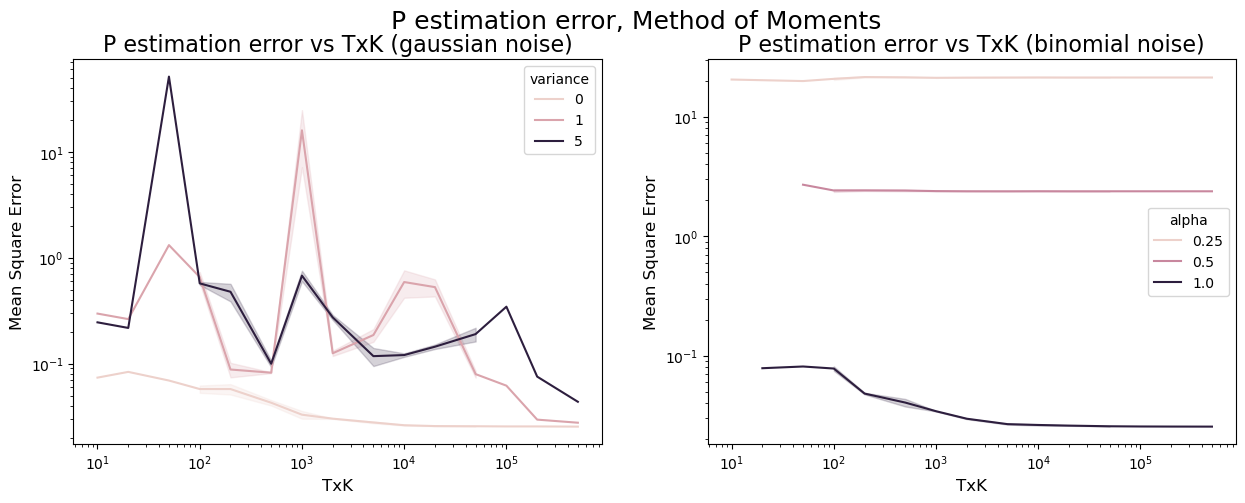

In [12]:
# Plot results

fig, ax = plt.subplots(1,2, figsize=(15,5))

for i, noise_type in enumerate(['gaussian', 'binomial']):
    data_che_uso = gauss_df if noise_type == 'gaussian' else binom_df
    y = data_che_uso[[f'error_MoM_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
    hue_val = 'variance' if noise_type == 'gaussian' else 'alpha'
    sns.lineplot(data=data_che_uso, x='TxK', y=y, hue=hue_val, ax=ax[i])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('TxK', fontsize=12)
    ax[i].set_ylabel('Mean Square Error', fontsize=12)
    ax[i].set_title(f'P estimation error vs TxK ({noise_type} noise)', fontsize=16)

fig.suptitle('P estimation error, Method of Moments', fontsize=18)
plt.show()

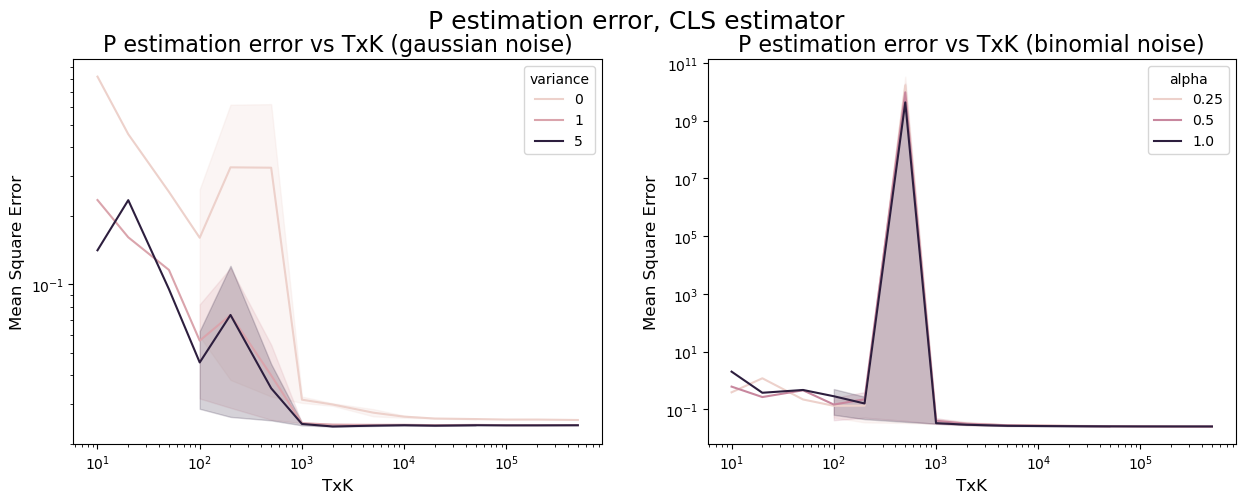

In [13]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i, noise_type in enumerate(['gaussian', 'binomial']):
    data_che_uso = gauss_df if noise_type == 'gaussian' else binom_df
    y = data_che_uso[[f'error_CLS_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
    hue_val = 'variance' if noise_type == 'gaussian' else 'alpha'
    sns.lineplot(data=data_che_uso, x='TxK', y=y, hue=hue_val, ax=ax[i])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('TxK', fontsize=12)
    ax[i].set_ylabel('Mean Square Error', fontsize=12)
    ax[i].set_title(f'P estimation error vs TxK ({noise_type} noise)', fontsize=16)

fig.suptitle('P estimation error, CLS estimator', fontsize=18)
plt.show()

### Experiment n° 2

For the second experiment, we assess the impact of the population size $N$.

In [14]:
N_range = [10**k for k in range(0,5)]
T = 10**5
K = 20

n_reps = 10

In [15]:
N_errors = []

for N in tqdm(N_range):
    dict_entry = {'N':N}

    for rep in range(n_reps):
        n_array, _, _ = create_observations(T=T,N=N,K=K,pi_0=pi_0,stationary=True)

        P_mom = P_mom_stationary(y_array = n_array, A = np.eye(S), N=N)
        P_cls = P_cls_stationary(y_array = n_array)

        dict_entry[f'error_MoM_{rep}'] = error_computation(P_mom)
        dict_entry[f'error_CLS_{rep}'] = error_computation(P_cls)

    N_errors.append(dict_entry)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:10<00:00, 38.07s/it]


In [16]:
N_df = pd.DataFrame(N_errors)
N_df.head()

,N,error_MoM_0,error_CLS_0,error_MoM_1,error_CLS_1,error_MoM_2,error_CLS_2,error_MoM_3,error_CLS_3,error_MoM_4,...,error_MoM_5,error_CLS_5,error_MoM_6,error_CLS_6,error_MoM_7,error_CLS_7,error_MoM_8,error_CLS_8,error_MoM_9,error_CLS_9
0,1,0.025436,0.025438,0.025415,0.025409,0.025357,0.025361,0.025418,0.025412,0.025434,...,0.025366,0.025366,0.025389,0.025396,0.025429,0.025429,0.025423,0.025417,0.025453,0.025458
1,10,0.025437,0.025437,0.025423,0.025424,0.025435,0.025435,0.025444,0.025445,0.025403,...,0.025455,0.025457,0.025402,0.025401,0.025429,0.025430,0.025455,0.025453,0.025437,0.025437
2,100,0.025476,0.025474,0.025448,0.025448,0.025422,0.025422,0.025415,0.025415,0.025425,...,0.025394,0.025394,0.025445,0.025446,0.025408,0.025408,0.025399,0.025399,0.025436,0.025435
3,1000,0.025385,0.025385,0.025389,0.025389,0.025450,0.025449,0.025473,0.025472,0.025432,...,0.025344,0.025344,0.025411,0.025411,0.025373,0.025373,0.025418,0.025418,0.025474,0.025474
4,10000,0.025404,0.025404,0.025435,0.025435,0.025406,0.025406,0.025461,0.025462,0.025431,...,0.025383,0.025383,0.025415,0.025415,0.025406,0.025406,0.025403,0.025403,0.025372,0.025372


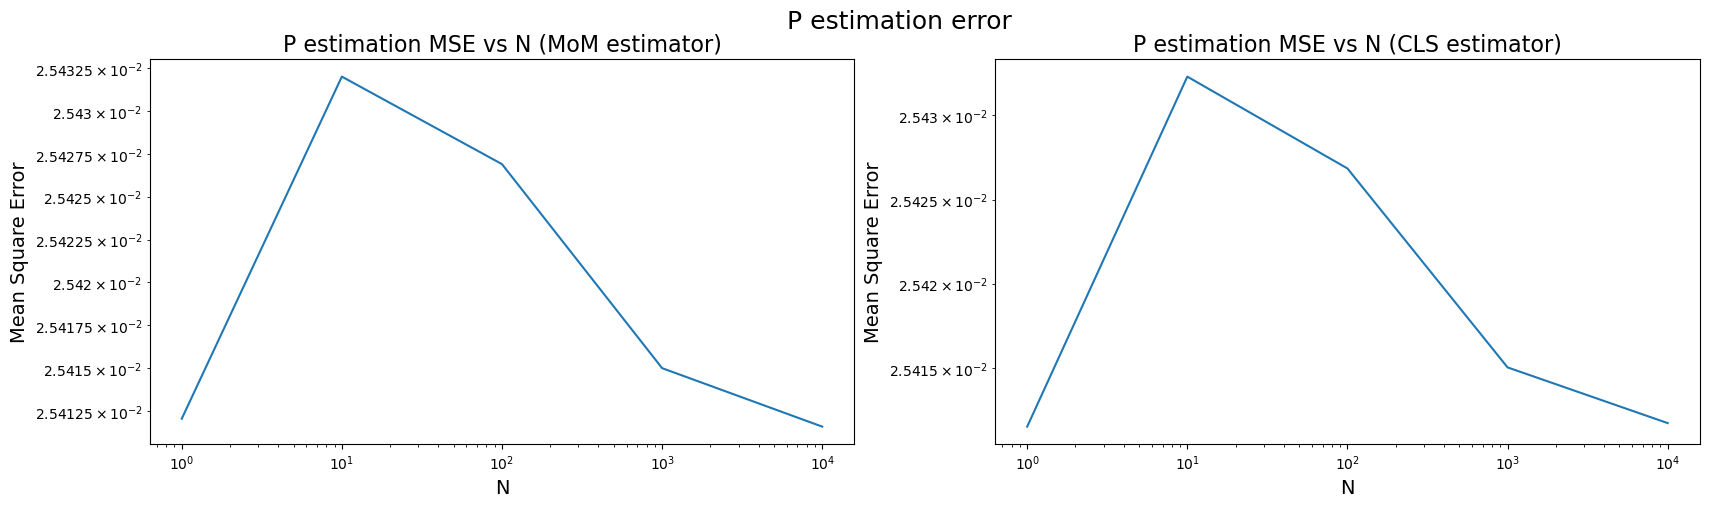

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

for i, estimator in enumerate(['MoM', 'CLS']):
    y = N_df[[f'error_{estimator}_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
    sns.lineplot(data=N_df, x='N', y=y, ax=ax[i])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('N', fontsize=14)
    ax[i].set_ylabel('Mean Square Error', fontsize=14)
    ax[i].set_title(f'P estimation MSE vs N ({estimator} estimator)', fontsize=16)

fig.suptitle('P estimation error', fontsize=18)
plt.show()

We can see that the error has the same order of magnitude, independently from $N$. This is in accordance with what's been found by the authors.

### Experiment n° 3

For the third experiment we compare our models against a naive baseline.